In [12]:
import os
import math
import time
import tarfile
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy import constants as cons
from astropy.table import Table, Column, vstack, join
import astropy.coordinates as coords
from astropy import units as u
from scipy import stats
import matplotlib.mlab as mlab

mpl.rc("font", family="serif", size=18)
mpl.rc("axes", linewidth = 1.0)
mpl.rc("lines", linewidth = 1.0)
mpl.rc("xtick.major", pad = 8, size = 10, width = 1)
mpl.rc("ytick.major", pad = 8, size = 10, width = 1)
mpl.rc("xtick.minor", size = 5, width = 1)
mpl.rc("ytick.minor", size = 5, width = 1)

#read the data 
hmscList = ascii.read('../Tables/hmscList_full_20161218.txt')
hiiList  = ascii.read('../Tables/hiiList_20161218.dat')
mmbList  = ascii.read('/Users/yuan/Desktop/MaserUTas/MMB/Tables/mmbGP_with_full_para_20161218.txt')
hiiList = hiiList[hiiList['Sp']>0.5]
mmbList = mmbList[mmbList['Sp_870']>0.5]
mmbList = mmbList[mmbList['L_M_ratio']<10000]
hiiList = hiiList[hiiList['L_M_ratio']<10000]
hmscList['Mclump'].mask[(hmscList['Mclump'].mask == True) | (hmscList['vlsr'].mask == True) ] = True
hmscList['Lclump'].mask[hmscList['Mclump'].mask==True] = True
hmscList['Dist_B'].mask[hmscList['Mclump'].mask==True] = True
hmscList['L_M_ratio'].mask[hmscList['Mclump'].mask==True] = True
hmscList['n_H2'].mask[hmscList['Mclump'].mask==True] = True
hmscList['r_pc'].mask[hmscList['Mclump'].mask==True] = True


In [13]:
pAngle = []
for isour in range(len(hmscList)):
    ra0  = hmscList['ra'][isour]
    dec0 = hmscList['dec'][isour]
    paG  = hmscList['PA'][isour]
    c1 = coords.SkyCoord(ra0,dec0,frame = 'fk5',
                         unit = (u.deg,u.deg))
    c2 = coords.SkyCoord(ra0,dec0+0.01,frame = 'fk5',
                         unit = (u.deg,u.deg))
    c1G = c1.galactic
    ang = c1G.position_angle(c2.galactic).deg
    pa  = paG+90-ang
    
    if pa<0:
        pa = pa+180
    
    if pa>180:
        pa = pa-180

    pAngle.append(pa)

pAngle = Column(pAngle, name = 'pa_new')

hmscList.add_column(pAngle)

In [14]:
massDense_hmsc = hmscList['Mclump']/(np.pi*hmscList['r_pc']**2)*0.00020890822
massDense_hii = hiiList['Mclump']/(np.pi*hiiList['r_pc']**2)*0.00020890822
massDense_mmb = mmbList['Mclump']/(np.pi*mmbList['r_pc']**2)*0.00020890822
massDense_hmsc.name = 'massDense'
massDense_hii.name = 'massDense'
massDense_mmb.name = 'massDense'

hmscList.add_column(massDense_hmsc)
mmbList.add_column(massDense_mmb)
hiiList.add_column(massDense_hii)
hmscList['L_M_ratio'].mask[hmscList['Mclump'].mask == True] = True


In [4]:
coreSub = hmscList[(hmscList['r_pc'] < 0.15)&(hmscList['r_pc'].mask == False)]
coreSub = coreSub['Name', 'Dist_B', 'r_pc', 'Tdust',
                 'Nh2', 'n_H2', 'massDense', 'Mclump', 'Lclump', 'L_M_ratio']
coreSub['Nh2'] = coreSub['Nh2']/1e22
coreSub['n_H2'] = coreSub['n_H2']/1e4
coreSub.write('../Tables/TableCore_para.txt', 
              format = 'ascii.fixed_width_no_header',delimiter = '&',
              formats = {'Dist_B':'%5.1f', 
                        'r_pc':'%5.2f', 'Tdust':'%5.2f', 
                        'Nh2':'%5.2f', 'n_H2':'%7.2f', 
                        'massDense':'%5.2f', 'Mclump':'%10.2f', 
                        'Lclump':'%10.2f', 'L_M_ratio':'%5.2f'})

/Users/yuan/anaconda/lib/python3.5/site-packages/astropy/table/column.py:1095: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [4]:
hmscListFull = hmscList['Name', 'ra', 'dec', 
                'raStr', 'decStr',  'amaj', 'amin', 'PA', 
                'FWHM', 'Sp', 'Sint', 'vlsr', 
                'Ref',  'Nh2', 'Tdust', 'Dist_B', 'Mclump', 'Lclump', 'L_M_ratio', 
                'r_pc', 'n_H2', 'massDense']
hmscListFull['Dist_B'].name = 'Distance'
hmscListFull['massDense'].unit = u.g/u.cm**2
hmscListFull['massDense'].name = 'Sigma_mass'

hmscListFull.write('../Tables/hmscFull_Para_20161223.txt',
                  format = 'ascii.ipac')

In [126]:
colStat = Column(['Min', 'Max', 'Median', 'Mean'], name = 'Stats')
disStat = Column([np.min(hmscList['Dist_B'][hmscList['Dist_B'].mask == False]), 
                  np.max(hmscList['Dist_B'][hmscList['Dist_B'].mask == False]),
                  np.median(hmscList['Dist_B'][hmscList['Dist_B'].mask == False]), 
                  np.mean(hmscList['Dist_B'][hmscList['Dist_B'].mask == False])],
                name = 'distance')
rpcStat = Column([np.min(hmscList['r_pc'][hmscList['r_pc'].mask == False]), 
                  np.max(hmscList['r_pc'][hmscList['r_pc'].mask == False]),
                  np.median(hmscList['r_pc'][hmscList['r_pc'].mask == False]), 
                  np.mean(hmscList['r_pc'][hmscList['r_pc'].mask == False])],
                name = 'r_pc')
TdStat  = Column([np.min(hmscList['Tdust'][hmscList['Tdust'].mask == False]), 
                  np.max(hmscList['Tdust'][hmscList['Tdust'].mask == False]),
                  np.median(hmscList['Tdust'][hmscList['Tdust'].mask == False]), 
                  np.mean(hmscList['Tdust'][hmscList['Tdust'].mask == False])],
                name = 'Tdust')
Nh2Stat = Column([np.min(hmscList['Nh2'][hmscList['Nh2'].mask == False]), 
                  np.max(hmscList['Nh2'][hmscList['Nh2'].mask == False]),
                  np.median(hmscList['Nh2'][hmscList['Nh2'].mask == False]), 
                  np.mean(hmscList['Nh2'][hmscList['Nh2'].mask == False])],
                name = 'Nh2')/1e22
nH2Stat = Column([np.min(hmscList['n_H2'][hmscList['n_H2'].mask == False]), 
                  np.max(hmscList['n_H2'][hmscList['n_H2'].mask == False]),
                  np.median(hmscList['n_H2'][hmscList['n_H2'].mask == False]), 
                  np.mean(hmscList['n_H2'][hmscList['n_H2'].mask == False])],
                name = 'n_H2')/1e4
mdenseStat = Column([np.min(hmscList['massDense'][hmscList['massDense'].mask == False]), 
                  np.max(hmscList['massDense'][hmscList['massDense'].mask == False]),
                  np.median(hmscList['massDense'][hmscList['massDense'].mask == False]), 
                  np.mean(hmscList['massDense'][hmscList['massDense'].mask == False])],
                name = 'massDense')
MclStat = Column([np.min(hmscList['Mclump'][hmscList['Mclump'].mask == False]), 
                  np.max(hmscList['Mclump'][hmscList['Mclump'].mask == False]),
                  np.median(hmscList['Mclump'][hmscList['Mclump'].mask == False]), 
                  np.mean(hmscList['Mclump'][hmscList['Mclump'].mask == False])],
                name = 'Mclump')
LclStat = Column([np.min(hmscList['Lclump'][hmscList['Lclump'].mask == False]), 
                  np.max(hmscList['Lclump'][hmscList['Lclump'].mask == False]),
                  np.median(hmscList['Lclump'][hmscList['Lclump'].mask == False]), 
                  np.mean(hmscList['Lclump'][hmscList['Lclump'].mask == False])],
                name = 'Lclump')
LMrStat = Column([np.min(hmscList['L_M_ratio'][hmscList['L_M_ratio'].mask == False]), 
                  np.max(hmscList['L_M_ratio'][hmscList['L_M_ratio'].mask == False]),
                  np.median(hmscList['L_M_ratio'][hmscList['L_M_ratio'].mask == False]), 
                  np.mean(hmscList['L_M_ratio'][hmscList['L_M_ratio'].mask == False])],
                name = 'L_M_ratio')

hmscStat = Table([colStat, disStat, rpcStat, TdStat,
                Nh2Stat, nH2Stat, mdenseStat, MclStat,
                LclStat, LMrStat])
hmscStat.write('../Tables/Stats_hmsc.txt', format = 'ascii.fixed_width_no_header',delimiter = '&',
             formats = {'distance':'%12.1f', 
                        'r_pc':'%10.2f', 'Tdust':'%10.2f', 
                        'Nh2':'%10.2f', 'n_H2':'%10.2f', 
                        'massDense':'%10.2f', 'Mclump':'%10.1e', 
                        'Lclump':'%10.1e', 'L_M_ratio':'%10.2f'})

In [127]:
colStat = Column(['Min', 'Max', 'Median', 'Mean'], name = 'Stats')
disStat = Column([np.min(mmbList['Dist_B'][mmbList['Dist_B'].mask == False]), 
                  np.max(mmbList['Dist_B'][mmbList['Dist_B'].mask == False]),
                  np.median(mmbList['Dist_B'][mmbList['Dist_B'].mask == False]), 
                  np.mean(mmbList['Dist_B'][mmbList['Dist_B'].mask == False])],
                name = 'distance')
rpcStat = Column([np.min(mmbList['r_pc'][mmbList['r_pc'].mask == False]), 
                  np.max(mmbList['r_pc'][mmbList['r_pc'].mask == False]),
                  np.median(mmbList['r_pc'][mmbList['r_pc'].mask == False]), 
                  np.mean(mmbList['r_pc'][mmbList['r_pc'].mask == False])],
                name = 'r_pc')
TdStat  = Column([np.min(mmbList['Tdust'][mmbList['Tdust'].mask == False]), 
                  np.max(mmbList['Tdust'][mmbList['Tdust'].mask == False]),
                  np.median(mmbList['Tdust'][mmbList['Tdust'].mask == False]), 
                  np.mean(mmbList['Tdust'][mmbList['Tdust'].mask == False])],
                name = 'Tdust')
Nh2Stat = Column([np.min(mmbList['Nh2'][mmbList['Nh2'].mask == False]), 
                  np.max(mmbList['Nh2'][mmbList['Nh2'].mask == False]),
                  np.median(mmbList['Nh2'][mmbList['Nh2'].mask == False]), 
                  np.mean(mmbList['Nh2'][mmbList['Nh2'].mask == False])],
                name = 'Nh2')/1e22
nH2Stat = Column([np.min(mmbList['n_H2'][mmbList['n_H2'].mask == False]), 
                  np.max(mmbList['n_H2'][mmbList['n_H2'].mask == False]),
                  np.median(mmbList['n_H2'][mmbList['n_H2'].mask == False]), 
                  np.mean(mmbList['n_H2'][mmbList['n_H2'].mask == False])],
                name = 'n_H2')/1e4
mdenseStat = Column([np.min(mmbList['massDense'][mmbList['massDense'].mask == False]), 
                  np.max(mmbList['massDense'][mmbList['massDense'].mask == False]),
                  np.median(mmbList['massDense'][mmbList['massDense'].mask == False]), 
                  np.mean(mmbList['massDense'][mmbList['massDense'].mask == False])],
                name = 'massDense')
MclStat = Column([np.min(mmbList['Mclump'][mmbList['Mclump'].mask == False]), 
                  np.max(mmbList['Mclump'][mmbList['Mclump'].mask == False]),
                  np.median(mmbList['Mclump'][mmbList['Mclump'].mask == False]), 
                  np.mean(mmbList['Mclump'][mmbList['Mclump'].mask == False])],
                name = 'Mclump')
LclStat = Column([np.min(mmbList['Lclump'][mmbList['Lclump'].mask == False]), 
                  np.max(mmbList['Lclump'][mmbList['Lclump'].mask == False]),
                  np.median(mmbList['Lclump'][mmbList['Lclump'].mask == False]), 
                  np.mean(mmbList['Lclump'][mmbList['Lclump'].mask == False])],
                name = 'Lclump')
LMrStat = Column([np.min(mmbList['L_M_ratio'][mmbList['L_M_ratio'].mask == False]), 
                  np.max(mmbList['L_M_ratio'][mmbList['L_M_ratio'].mask == False]),
                  np.median(mmbList['L_M_ratio'][mmbList['L_M_ratio'].mask == False]), 
                  np.mean(mmbList['L_M_ratio'][mmbList['L_M_ratio'].mask == False])],
                name = 'L_M_ratio')

mmbStat = Table([colStat, disStat, rpcStat, TdStat,
                Nh2Stat, nH2Stat, mdenseStat, MclStat,
                LclStat, LMrStat])
mmbStat.write('../Tables/Stats_mmb.txt', format = 'ascii.fixed_width_no_header',delimiter = '&',
             formats = {'distance':'%12.1f', 
                        'r_pc':'%10.2f', 'Tdust':'%10.2f', 
                        'Nh2':'%10.2f', 'n_H2':'%10.2f', 
                        'massDense':'%10.2f', 'Mclump':'%10.1e', 
                        'Lclump':'%10.1e', 'L_M_ratio':'%10.2f'})

In [128]:
colStat = Column(['Min', 'Max', 'Median', 'Mean'], name = 'Stats')
disStat = Column([np.min(hiiList['Dist_B']), 
                  np.max(hiiList['Dist_B']),
                  np.median(hiiList['Dist_B']), 
                  np.mean(hiiList['Dist_B'])],
                name = 'distance')
rpcStat = Column([np.min(hiiList['r_pc']), 
                  np.max(hiiList['r_pc']),
                  np.median(hiiList['r_pc']), 
                  np.mean(hiiList['r_pc'])],
                name = 'r_pc')
TdStat  = Column([np.min(hiiList['Tdust']), 
                  np.max(hiiList['Tdust']),
                  np.median(hiiList['Tdust']), 
                  np.mean(hiiList['Tdust'])],
                name = 'Tdust')
Nh2Stat = Column([np.min(hiiList['Nh2']), 
                  np.max(hiiList['Nh2']),
                  np.median(hiiList['Nh2']), 
                  np.mean(hiiList['Nh2'])],
                name = 'Nh2')/1e22
nH2Stat = Column([np.min(hiiList['n_H2']), 
                  np.max(hiiList['n_H2']),
                  np.median(hiiList['n_H2']), 
                  np.mean(hiiList['n_H2'])],
                name = 'n_H2')/1e4
mdenseStat = Column([np.min(hiiList['massDense']), 
                  np.max(hiiList['massDense']),
                  np.median(hiiList['massDense']), 
                  np.mean(hiiList['massDense'])],
                name = 'massDense')
MclStat = Column([np.min(hiiList['Mclump']), 
                  np.max(hiiList['Mclump']),
                  np.median(hiiList['Mclump']), 
                  np.mean(hiiList['Mclump'])],
                name = 'Mclump')
LclStat = Column([np.min(hiiList['Lclump']), 
                  np.max(hiiList['Lclump']),
                  np.median(hiiList['Lclump']), 
                  np.mean(hiiList['Lclump'])],
                name = 'Lclump')
LMrStat = Column([np.min(hiiList['L_M_ratio']), 
                  np.max(hiiList['L_M_ratio']),
                  np.median(hiiList['L_M_ratio']), 
                  np.mean(hiiList['L_M_ratio'])],
                name = 'L_M_ratio')

hiiStat = Table([colStat, disStat, rpcStat, TdStat,
                Nh2Stat, nH2Stat, mdenseStat, MclStat,
                LclStat, LMrStat])
hiiStat.write('../Tables/Stats_hii.txt', format = 'ascii.fixed_width_no_header',delimiter = '&',
             formats = {'distance':'%12.1f', 
                        'r_pc':'%10.2f', 'Tdust':'%10.2f', 
                        'Nh2':'%10.2f', 'n_H2':'%10.2f', 
                        'massDense':'%10.2f', 'Mclump':'%10.1e', 
                        'Lclump':'%10.1e', 'L_M_ratio':'%10.2f'})

In [79]:
TableCat = hmscList['Name', 'raStr', 'decStr', 'amaj', 'amin', 
                    'pa_new', 'FWHM', 'vlsr', 'Dist_B', 'sigma_D', 'Ref', 'Dark70']
TablePara = hmscList['Name', 'r_pc', 'Tdust', 'Nh2',
                   'n_H2', 'massDense', 'Mclump',
                   'Lclump', 'L_M_ratio']

TablePara['Nh2'] = TablePara['Nh2']/1e22

TablePara['n_H2'] = TablePara['n_H2']/1e4



TableCat.write('../Tables/TableCat_20161218.txt', format = 'ascii.ipac',
               formats = {'amaj':'%5d', 'amin':'%5d', 
                          'pa_new':'%8.1f', 'FWHM':'%5d', 
                          'vlsr':'%8.2f', 'Dist_B':'%8.2f', 
                          'sigma_D':'%8.2f'})
TablePara.write('../Tables/TablePara_20161218.txt', format = 'ascii.ipac',
               formats = {'r_pc':'%8.2f', 'Tdust':'%8.2f', 
                          'Nh2':'%8.2f','n_H2':'%8.2f', 
                          'massDense':'%8.2f', 'Mclump':'%8.2e',
                          'Lclump':'%8.2e', 'L_M_ratio':'%8.2f'})


/Users/yuan/anaconda/lib/python3.5/site-packages/astropy/table/column.py:1095: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [80]:
sourInPaper = ascii.read('../Tables/sourcesInPaper.txt')
TableCat_short = join(TableCat, sourInPaper)
TablePara_short = join(TablePara,sourInPaper)

TableCat_short.write('../Tables/TableCat_short.txt', format = 'ascii.fixed_width_no_header',
                     formats = {'amaj':'%5d', 'amin':'%5d', 
                          'pa_new':'%8.0f', 'FWHM':'%5d', 
                          'vlsr':'%8.2f', 'Dist_B':'%8.2f', 
                          'sigma_D':'%8.2f'},
                    delimiter = '&')
TablePara_short.write('../Tables/TablePara_short.txt', format = 'ascii.fixed_width_no_header',
               formats = {'r_pc':'%8.2f', 'Tdust':'%8.2f', 
                          'Nh2':'%8.2f','n_H2':'%8.2f', 
                          'massDense':'%8.2f', 'Mclump':'%8.2e',
                          'Lclump':'%8.2e', 'L_M_ratio':'%8.2f'},
                    delimiter = '&')

In [15]:
coors = coords.SkyCoord(hmscList['ra'], hmscList['dec'],
                       frame = 'fk5', unit = (u.deg,u.deg))
l = Column(coors.galactic.l.deg, name = 'l')
b = Column(coors.galactic.b.deg, name = 'b')
hmscList.add_columns([l,b])


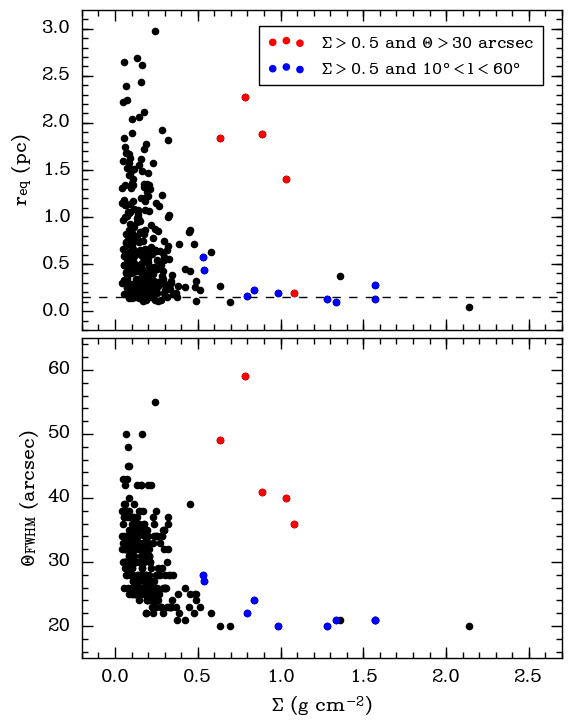

In [10]:
%matplotlib inline
mpl.rc("font", family="serif", size=16)
mpl.rc("axes", linewidth = 1.0)
mpl.rc("lines", linewidth = 1.0)
mpl.rc("xtick.major", pad = 8, size = 8, width = 1)
mpl.rc("ytick.major", pad = 8, size = 8, width = 1)
mpl.rc("xtick.minor", size = 4, width = 1)
mpl.rc("ytick.minor", size = 4, width = 1)
fig = plt.figure(1, figsize = (8,8))
ax1 = fig.add_axes([0.1,0.51,0.6,0.4])
ax1.plot([-0.2,2.7],[0.15,0.15], '--k', label = None)
ax1.scatter(hmscList['massDense'], hmscList['r_pc'], 
           marker = 'o', color = 'black', label = None)
ax1.scatter(hmscList['massDense'][(hmscList['massDense'] > 0.5)&(hmscList['FWHM'] > 30)], 
            hmscList['r_pc'][(hmscList['massDense'] > 0.5)&(hmscList['FWHM'] > 30)], 
            marker = 'o', color = 'red',
            label = "$\Sigma>0.5$ and $\Theta>30$ arcsec")
ax1.scatter(hmscList['massDense'][(hmscList['massDense'] > 0.5)&(l>10)&(l<60)], 
            hmscList['r_pc'][(hmscList['massDense'] > 0.5)&(l>10)&(l<60)],
            marker = 'o', color = 'blue',
            label = "$\Sigma>0.5$ and $10\degree<l<60\degree$")
ax1.legend(fontsize = 14, bbox_to_anchor=(0.98, 0.98))
ax1.minorticks_on()
ax1.set_xlim(-0.2,2.7)
ax1.set_ylim(-0.2,3.2)
ax1.set_xticklabels([])
ax1.set_ylabel('r$_{eq}$ (pc)')

ax2 = fig.add_axes([0.1,0.1,0.6,0.4])
ax2.scatter(hmscList['massDense'], hmscList['FWHM'], 
           marker = 'o', color = 'black')
ax2.scatter(hmscList['massDense'][(hmscList['massDense'] > 0.5)&(hmscList['FWHM'] > 30)], 
            hmscList['FWHM'][(hmscList['massDense'] > 0.5)&(hmscList['FWHM'] > 30)], 
           marker = 'o', color = 'red' )
ax2.scatter(hmscList['massDense'][(hmscList['massDense'] > 0.5)&(l>10)&(l<60)], 
            hmscList['FWHM'][(hmscList['massDense'] > 0.5)&(l>10)&(l<60)], 
           marker = 'o', color = 'blue')
ax2.minorticks_on()
ax2.set_xlim(-0.2,2.7)
ax2.set_ylim(15,65)
#ax2.set_xticklabels([])
ax2.set_xlabel('$\Sigma$ (g cm$^{-2}$)')
ax2.set_ylabel('$\Theta_{FWHM}$ (arcsec)')
fig.savefig('../epsFigs/Size_vs_sigma.pdf',
            bbox_inches='tight', papertype='a2')
fig.savefig('../epsFigs/Size_vs_sigma.eps',
            bbox_inches='tight', papertype='a2')